In [7]:
import torch
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.2, activationfn='tanh',):
        super(SentimentRNN, self).__init__()
        
        # RNN layer
        self.rnn = nn.RNN(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True, 
            dropout=dropout, 
            nonlinearity=activationfn, 
            bias=True
            )
        
        # Normalization layer
        # self.norm = nn.LayerNorm(hidden_size)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Sigmoid activation for output
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pass input through RNN
        out, hidden = self.rnn(x)
        
        out = torch.mean(out, dim=1) # mean over the sequence length
        
        # Pass through the fully connected layer and activation
        out = self.fc(out)
        # out = self.sigmoid(out)
        
        return out


In [8]:
# Define model parameters
input_size = 100         # Dimension of Word2Vec embeddings
hidden_size = 128        # Number of hidden units
output_size = 1          # Output size (1 for binary classification)
num_layers = 2           # Number of stacked RNN layers
dropout = 0.25        # Dropout rate for regularization




In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

class SentimentDataset(Dataset):
    def __init__(self, dataset, word2vec_model, max_length=100):
        self.dataset = dataset
        self.word2vec = word2vec_model
        self.max_length = max_length  # Maximum sequence length for padding

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get text and label
        text = self.dataset[idx]['text']
        label = self.dataset[idx]['label']
        
        # Convert text to embeddings
        tokens = text # Assuming text is tokenized already
        embeddings = [self.word2vec.wv[word] for word in tokens if word in self.word2vec.wv]
        
        # Truncate sequences - will pad later
        if len(embeddings) > self.max_length:
            embeddings = embeddings[:self.max_length]
        
        embeddings = np.array(embeddings)
        
        return torch.tensor(embeddings, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

def collate_fn(batch):
    # Separate embeddings and labels
    embeddings = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    
    # Stack them into tensors
    embeddings = pad_sequence(embeddings, batch_first=True)
    labels = torch.stack(labels)
    
    return embeddings, labels


In [10]:
from gensim.models import Word2Vec
from datasets import load_from_disk

# This is the training dataset
path_to_train_set = r"C:\Users\All Saints\Desktop\Uni mods\SC4002\SC4002_NLP_Project\tokenised_datasets\tokenised_train_dataset"
train_dataset = load_from_disk(path_to_train_set)

# This is the word2vec model
word2vec_model = Word2Vec.load('word2vec.model')

# Assuming 'train_dataset' is your dataset and 'word2vec_model' is your Word2Vec model
train_data = SentimentDataset(train_dataset, word2vec_model)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)


In [11]:
c=0
for embeddings, labels in train_loader:
    print(embeddings.shape, labels.shape)
    c+=1
    if c==123:
        break


torch.Size([32, 37, 100]) torch.Size([32])
torch.Size([32, 34, 100]) torch.Size([32])
torch.Size([32, 35, 100]) torch.Size([32])
torch.Size([32, 44, 100]) torch.Size([32])
torch.Size([32, 43, 100]) torch.Size([32])
torch.Size([32, 30, 100]) torch.Size([32])
torch.Size([32, 37, 100]) torch.Size([32])
torch.Size([32, 35, 100]) torch.Size([32])
torch.Size([32, 39, 100]) torch.Size([32])
torch.Size([32, 37, 100]) torch.Size([32])
torch.Size([32, 36, 100]) torch.Size([32])
torch.Size([32, 37, 100]) torch.Size([32])
torch.Size([32, 41, 100]) torch.Size([32])
torch.Size([32, 35, 100]) torch.Size([32])
torch.Size([32, 31, 100]) torch.Size([32])
torch.Size([32, 36, 100]) torch.Size([32])
torch.Size([32, 35, 100]) torch.Size([32])
torch.Size([32, 35, 100]) torch.Size([32])
torch.Size([32, 51, 100]) torch.Size([32])
torch.Size([32, 31, 100]) torch.Size([32])
torch.Size([32, 37, 100]) torch.Size([32])
torch.Size([32, 45, 100]) torch.Size([32])
torch.Size([32, 42, 100]) torch.Size([32])
torch.Size(

Epoch 1/150, Loss: 0.6945, Accuracy: 0.4912
Epoch 2/150, Loss: 0.6937, Accuracy: 0.4910
Epoch 3/150, Loss: 0.6935, Accuracy: 0.5000
Epoch 4/150, Loss: 0.6932, Accuracy: 0.5063
Epoch 5/150, Loss: 0.6933, Accuracy: 0.4959
Epoch 6/150, Loss: 0.6934, Accuracy: 0.5001
Epoch 7/150, Loss: 0.6932, Accuracy: 0.5023
Epoch 8/150, Loss: 0.6933, Accuracy: 0.5015
Epoch 9/150, Loss: 0.6931, Accuracy: 0.5079
Epoch 10/150, Loss: 0.6932, Accuracy: 0.5067
Epoch 11/150, Loss: 0.6932, Accuracy: 0.4998
Epoch 12/150, Loss: 0.6930, Accuracy: 0.5103
Epoch 13/150, Loss: 0.6930, Accuracy: 0.5122
Epoch 14/150, Loss: 0.6928, Accuracy: 0.5161
Epoch 15/150, Loss: 0.6926, Accuracy: 0.5199
Epoch 16/150, Loss: 0.6927, Accuracy: 0.5149
Epoch 17/150, Loss: 0.6927, Accuracy: 0.5087
Epoch 18/150, Loss: 0.6926, Accuracy: 0.5150
Epoch 19/150, Loss: 0.6925, Accuracy: 0.5156
Epoch 20/150, Loss: 0.6918, Accuracy: 0.5236
Epoch 21/150, Loss: 0.6915, Accuracy: 0.5237
Epoch 22/150, Loss: 0.6906, Accuracy: 0.5358
Epoch 23/150, Loss:

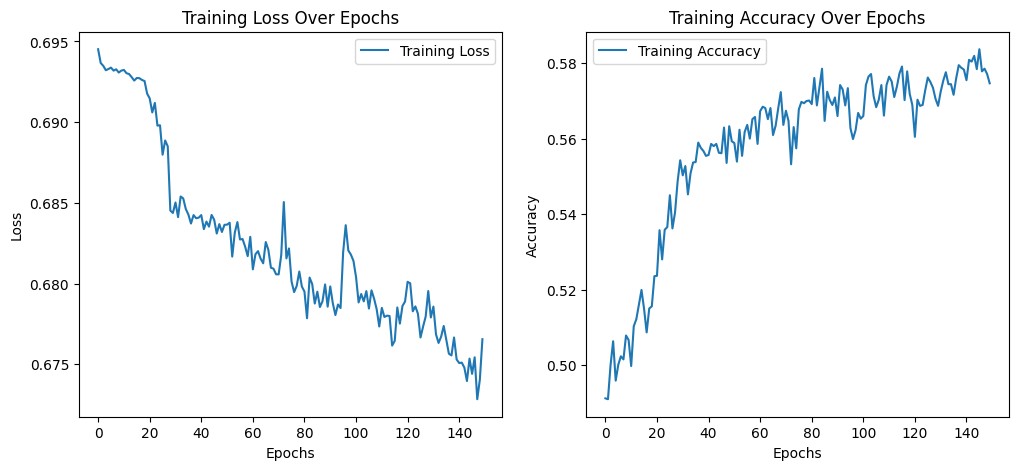

In [12]:
import matplotlib.pyplot as plt
import torch.optim as optim

# Binary Cross-Entropy Loss with Logits
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer with the model's parameters and a learning rate
learning_rate = 0.0004

# Initialize the model
model = SentimentRNN(input_size, hidden_size, output_size, num_layers, dropout)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Set the model to training mode
model.train()

# Training parameters
num_epochs = 150
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for embeddings, labels in train_loader:
        # Move data to the same device as model (GPU if available)
        # embeddings, labels = embeddings.to('cuda'), labels.to('cuda')
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(embeddings).squeeze()  # Output shape is (batch_size,)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print the gradients
        # for name, param in model.named_parameters():
        #     print(name, param.grad)
        
        # Accumulate the loss and accuracy
        epoch_loss += loss.item() * labels.size(0)  # Multiply by batch size for total loss
        predictions = (torch.sigmoid(outputs) >= 0.5).float()  # Threshold at 0.5
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / total_samples
    accuracy = correct_predictions / total_samples
    
    # Store metrics for plotting
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

# Plot the training loss and accuracy over epochs
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Epochs")
plt.legend()

plt.show()
